In [33]:
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import shap
le = LabelEncoder()

In [34]:
train = pd.read_csv('train_modified.csv')
test = pd.read_csv('test_modified.csv')

In [40]:
train

,Unnamed: 0,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,MRP_Per_Gram,Log_Item_Visibility,Outlet_Age
0,0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,26.861204,0.015920,26
1,1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,8.153581,0.019095,16
2,2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,8.092457,0.016621,26
3,3,FDX07,19.200,Regular,0.015274,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,9.484115,0.015158,27
4,4,NCD19,8.930,Low Fat,0.008082,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,6.031512,0.008050,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834,31.248623,0.055230,38
8519,8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,Medium,Tier 2,Supermarket Type1,549.2850,12.906563,0.045912,23
8520,8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136,8.030415,0.034581,21
8521,8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976,14.304189,0.135597,16


In [41]:
cat_cols = [col for col in train.columns if train[col].dtype == 'object']
train[cat_cols] = train[cat_cols].astype('category')
test[cat_cols] = test[cat_cols].astype('category')

In [42]:
train_cols = ['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'MRP_Per_Gram', 'Log_Item_Visibility']

In [43]:
X_train, X_val, y_train, y_val = train_test_split(train[train_cols], train['Item_Outlet_Sales'], test_size=0.25, random_state=42)

In [147]:
dtrain = lgb.Dataset(X_train, y_train)
deval = lgb.Dataset(X_val, y_val)

# dtrain_xgb = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
# deval_xgb = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)


# params_xgb = {'objective':'reg:squarederror',
#           'learning_rate':0.005,
#           'max_depth':3
#          }

params = {'objective':'tweedie',
          'learning_rate':0.001,
          'metric':'rmse',
          'max_depth': 3,
          'num_leaves': 7,
          'alpha': 0.5,
          'tweedie_variance_power':1.6
         }

### Tried different objectives like regression(L2), tweedie and quantile because the target variable is skewed and linear loss function will not model it correctly and provide false results.

### Also, tried Xgboost and Lightgbm algorithms, Lightgbm providing better results with tweedie as objective and parameter tuning.

In [148]:
# model_xgb = xgb.train(params_xgb, dtrain_xgb, num_boost_round=5000,
#                       evals = [(dtrain_xgb, 'train'), (deval_xgb, 'eval')],
#                      early_stopping_rounds=10)

In [149]:
model = lgb.train(params, dtrain, num_boost_round=5000, valid_sets=[dtrain, deval], callbacks=[lgb.early_stopping(10)])

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2634
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 13
[LightGBM] [Info] Start training from score 7.700738
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4668]	training's rmse: 1071.66	valid_1's rmse: 1040.65


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

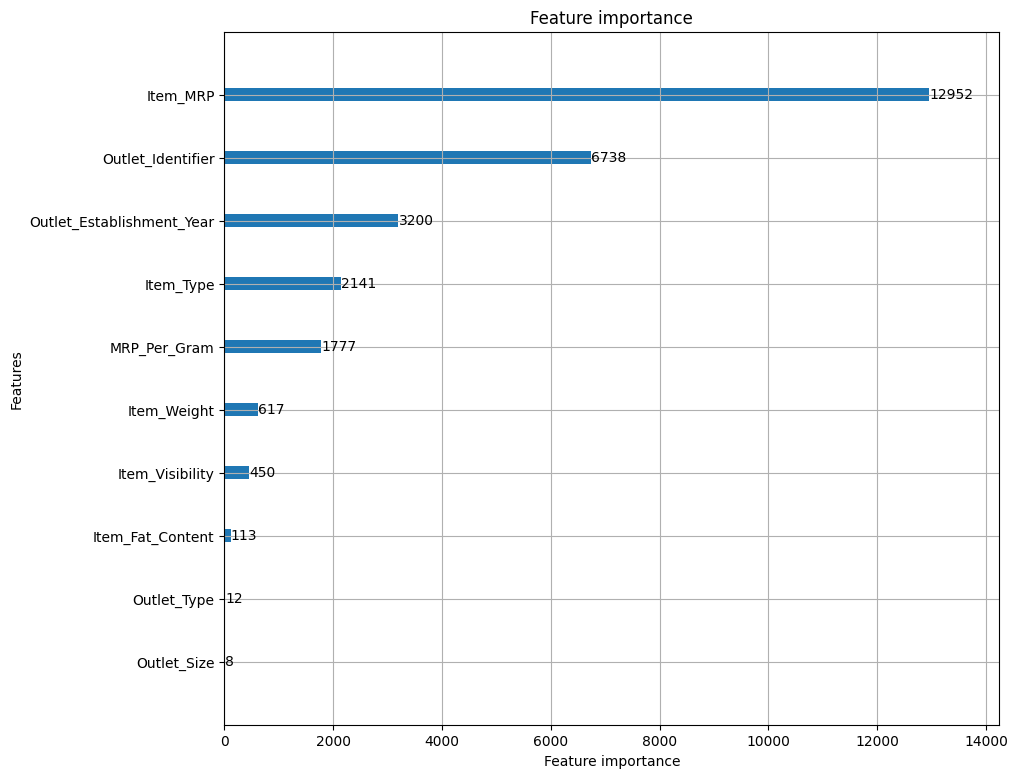

In [150]:
feature_importance_df = pd.DataFrame({'feature_name': model.feature_name(),'tree_split': model.feature_importance(importance_type='split')})
feature_importance_df = feature_importance_df.sort_values(by='tree_split', ascending=False)
feature_importance_df['xgb_rank'] = feature_importance_df['tree_split'].rank(method='first',ascending=False).astype(int)
lgb.plot_importance(model, max_num_features = 20,figsize=(10, 9))

In [151]:
#test.drop('Unnamed: 0', axis=1, inplace=True)

In [152]:
#xgb_test = xgb.DMatrix(test, enable_categorical=True)
#preds = model_xgb.predict(xgb_test)
preds = model.predict(test)

In [153]:
valid_preds = [abs(pred) for pred in preds]

In [154]:
submission['Item_Outlet_Sales'] = valid_preds

In [155]:
len([pred for pred in valid_preds if pred < 0])

0

In [156]:
submission.to_csv('IJ_Sub_v10_lgb.csv', index=False)